In [98]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import pyart

# Read in baseline info
# (dbz95, clutterflag indices)

from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_baseline_20181102.nc')
print(dataset.dimensions.keys())
print(dataset.variables.keys())
PCT_on_50 = dataset.variables['Flagged clutter grid gates'][:,:]
dbz95_base = dataset.variables['Baseline 95th reflectivity'][:]
dbz95_baseCAR = dataset.variables['Baseline 95th reflectivity CAR'][:]
dataset.close()

print(dbz95_base)
print(dbz95_baseCAR)
print(PCT_on_50.shape)
#print(PCT_on_50[:,5])
for i in range(0,len(PCT_on_50[:,0])):
    for j in range(0,len(PCT_on_50[0,:])):
        #print(i,0,'j = 0 is nan')
        if np.isfinite(PCT_on_50[i,j]):
            print(i,j,'FINITE NUMBER')

odict_keys(['azi', 'rang', 'value'])
odict_keys(['Flagged clutter grid gates', 'Baseline 95th reflectivity', 'Baseline 95th reflectivity CAR'])
[49.54123825]
[49.21285999]
(360, 6)
195 3 FINITE NUMBER
201 3 FINITE NUMBER
203 3 FINITE NUMBER
204 3 FINITE NUMBER
205 3 FINITE NUMBER
208 3 FINITE NUMBER
210 3 FINITE NUMBER
212 3 FINITE NUMBER
213 2 FINITE NUMBER
213 3 FINITE NUMBER
215 3 FINITE NUMBER
220 3 FINITE NUMBER
221 3 FINITE NUMBER
222 2 FINITE NUMBER
222 3 FINITE NUMBER
223 3 FINITE NUMBER
226 3 FINITE NUMBER
229 2 FINITE NUMBER
229 3 FINITE NUMBER
230 3 FINITE NUMBER
235 3 FINITE NUMBER
236 3 FINITE NUMBER
240 2 FINITE NUMBER
241 3 FINITE NUMBER
245 2 FINITE NUMBER
246 2 FINITE NUMBER
247 2 FINITE NUMBER
250 2 FINITE NUMBER
252 2 FINITE NUMBER
252 3 FINITE NUMBER
254 3 FINITE NUMBER
255 2 FINITE NUMBER
256 3 FINITE NUMBER
257 2 FINITE NUMBER
258 3 FINITE NUMBER
259 3 FINITE NUMBER
260 2 FINITE NUMBER
260 3 FINITE NUMBER
263 2 FINITE NUMBER
264 2 FINITE NUMBER
264 3 FINITE NUMBER

In [101]:
def rca_function(filename):
    '''Creates a clutter map (precip-free day) to be used for the RCA calculation for PPIs'''
    from netCDF4 import Dataset
    dataset = Dataset('/home/hunzinger/data/rca_cluttermap_baseline_20181102.nc')
#print(dataset.dimensions.keys())
#print(dataset.variables.keys())
    PCT_on_50 = dataset.variables['Flagged clutter grid gates'][:,:]
    dbz95_base = dataset.variables['Baseline 95th reflectivity'][:]
    dbz95_baseCAR = dataset.variables['Baseline 95th reflectivity CAR'][:]
    dataset.close()
    
    radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 5000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zdr = radar.fields['differential_reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    theta = theta[sorted_idx]

    # Create a fixed polar grid/array (FPG; 1 deg x 1 km)
    #r_grid = np.array((0,1,2,3,4,5))*1000.
    #theta_grid = theta
    #r_matrix, theta_matrix = np.meshgrid(r_grid,theta_grid)
    
    # Create array to store qualifying reflectivities (fall within PCT_on > 0.5)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan
    
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    for i in range(0,len(PCT_on_50[:,0])):
        for j in range(0,len(PCT_on_50[0,:])):
            if np.isfinite(PCT_on_50[i,j]):
                zh_car[i,j*10-10:j*10] = zh[i,j*10-10:j*10]
            #else:
            #    zh_car[i,j*10-10:j*10-1] = np.nan
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zh_car))  
    n,bins,patches=plt.hist(zh_car[mask],bins=105,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    
    x = np.arange(105)-40
    coeff = np.polyfit(p,x,3) # Find coefficients of 10th degree polynomial for CDF
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    # Calculate RCA using baseline dbz95
    # RCA = dbz95baseline - dbz95daily
    rca = dbz95_base[0] - dbz95
    rcaCAR = dbz95_baseCAR[0] - dbz95
    
    del radar
    return zh_car, date_time, n, bins, p, dbz95, dbz95_base[0], dbz95_baseCAR[0], rca


/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181102.231504.nc


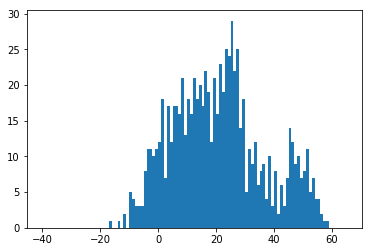

In [102]:
# Run this function on a bunch of files (try data from one day)
import os
import glob

zh = []
dt = []
n = []
bins = []
cdf = []
p = []
dbz95 = []
dbz95base = []
dbz95baseCAR = []
rca = []



for f in glob.glob(os.path.join('/home/hunzinger/data/ppi_cf/', 'corcsapr2cfrppi*.20181102.2315*.nc')):
    print(f)
    ZH, DateTime, N, Bins, P, DBZ95, DBZ95BASE, DBZ95BASECAR, RCA = rca_function(f)
    
    # Put all PPI times into a list
    zh.append(ZH)
    dt.append(DateTime)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)
    dbz95base.append(DBZ95BASE)
    dbz95baseCAR.append(DBZ95BASECAR)
    rca.append(RCA)

In [104]:
print(dbz95base)
print(dbz95baseCAR)
print(dbz95)
print(rca, rcaCAR)
mean_rca = np.nanmean(rca)
print(mean_rca)

[49.541238247840845]
[49.21285998656316]
[50.472155554536144]


NameError: name 'rcaCAR' is not defined